### https://amsterdam.luminis.eu/2017/02/21/coding-doc2vec/

### https://amsterdam.luminis.eu/2017/01/30/implementing-doc2vec/

### Fork from https://github.com/luminis-ams/blog-doc2vec/blob/master/pvdbow.ipynb

In [27]:
import collections
import re

import numpy as np
import pandas as pd
import tensorflow as tf

import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('reuters')
nltk.download('punkt')

PERCENTAGE_DOCS = 100 # random subsample of Reuters training docs
VOCAB_SIZE = 10000
REMOVE_TOP_K_TERMS = 100
MIN_TERM_FREQ = 5

TEXT_WINDOW_SIZE = 8
BATCH_SIZE = 10 * TEXT_WINDOW_SIZE
EMBEDDING_SIZE = 128
SHUFFLE_EVERY_X_EPOCH = 5
PV_TEST_SET_PERCENTAGE = 5
NUM_STEPS = 100001
LEARNING_RATE = 0.1
NUM_SAMPLED = 64
REPORT_EVERY_X_STEPS = 2000

END_TO_END_EVERY_X_STEPS = 30000
E2E_TEST_SET_PERCENTAGE = 30
TSNE_NUM_DOCS = 400

# Token integer ids for special tokens
UNK = 0
NULL = 1

[nltk_data] Downloading package reuters to
[nltk_data]     /usr/local/google/home/haojing/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/google/home/haojing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
"""
Returns an eternal generator, periodically shuffling the order

l_ is a list of integers; an internal copy of it is maintained.
"""
def repeater_shuffler(l_):
    l = np.array(l_, dtype=np.int32)
    epoch = 0
    while epoch >= 0:
        if epoch % SHUFFLE_EVERY_X_EPOCH == 0:
            np.random.shuffle(l)
        for i in l:
            yield i
        epoch += 1
        
        
def accept_doc(fileid):
    return fileid.startswith('training/') \
            and np.random.random() * 100 < PERCENTAGE_DOCS

    
def accept(word):
    # Accept if not only Unicode non-word characters are present
    return re.sub(r'\W', '', word) != ''


def normalize(word):
    return word.lower()


def build_dataset():
    fileid2words = {fileid:
            [normalize(word) for word in word_tokenize(
                    reuters.raw(fileid)) if accept(word)] \
            for fileid in reuters.fileids() if accept_doc(fileid)}
    count = [['__UNK__', 0], ['__NULL__', 0]]
    count.extend([(word, count) for word, count in collections.Counter(
            [word for words in fileid2words.values() \
            for word in words]).most_common(
                    VOCAB_SIZE - 2 + REMOVE_TOP_K_TERMS)[
                            REMOVE_TOP_K_TERMS:
                    ] if count >= MIN_TERM_FREQ])
    assert not set(['__UNK__', '__NULL__']) & set(next(zip(
            *count[2:])))
    dictionary = {}
    for i, (word, _) in enumerate(count):
        dictionary[word] = i
    reverse_dictionary = dict(zip(dictionary.values(),
                                  dictionary.keys()))
    data = []
    doclens = []
    fileids = []
    for docid, (fileid, words) in enumerate(fileid2words.items()):
        for word in words:
            if word in dictionary:
                wordid = dictionary[word]
            else:
                wordid = UNK
                count[UNK][1] += 1
            data.append((docid, wordid))
        # Pad with NULL values if necessary
        doclen = len(words)
        doclens.append(doclen)
        fileids.append(fileid)
        if doclen < TEXT_WINDOW_SIZE:
            n_nulls = TEXT_WINDOW_SIZE - doclen
            data.extend([(docid, NULL)] * n_nulls)
            count[NULL][1] += n_nulls
    return data, count, doclens, fileids, dictionary, reverse_dictionary

In [29]:
data, count, doclens, fileids, dictionary, reverse_dictionary = \
        build_dataset()

In [30]:

print('Number of documents:', len(set(next(zip(*data)))))
print('Number of tokens:', len(data))
print('Number of unique tokens:', len(count))
assert len(data) == sum([i for _, i in count])
print('Most common words (+UNK and NULL):', count[:5])
print('Least common words:', count[-5:])
print('Sample data:', data[:5])
vocab_size = min(VOCAB_SIZE, len(count))
print('Effective vocab size:', vocab_size)

Number of documents: 7769
Number of tokens: 1023352
Number of unique tokens: 10000
Most common words (+UNK and NULL): [['__UNK__', 524065], ['__NULL__', 244], ('dollar', 1112), ('foreign', 1101), ('rose', 1096)]
Least common words: [('22.50', 5), ('typical', 5), ('ufcw', 5), ('manpower', 5), ('deng', 5)]
Sample data: [(0, 1114), (0, 0), (0, 537), (0, 0), (0, 616)]
Effective vocab size: 10000


In [31]:
pd.Series(doclens).describe()

count    7769.000000
mean      131.691080
std       138.805498
min         2.000000
25%        46.000000
50%        87.000000
75%       165.000000
max      1321.000000
dtype: float64

In [32]:
def get_text_window_center_positions():
    # If TEXT_WINDOW_SIZE is even, then define text_window_center
    # as left-of-middle-pair
    doc_start_indexes = [0]
    last_docid = data[0][0]
    
    # get starting indexes of docs
    for i, (d, _) in enumerate(data):
        if d != last_docid:
            doc_start_indexes.append(i)
            last_docid = d
    twcp = []
    for i in range(len(doc_start_indexes) - 1):
        twcp.extend(list(range(
                doc_start_indexes[i] + (TEXT_WINDOW_SIZE - 1) // 2,
                doc_start_indexes[i + 1] - TEXT_WINDOW_SIZE // 2
                )))
    return doc_start_indexes, twcp

doc_start_indexes, twcp = get_text_window_center_positions()

In [33]:
print(doc_start_indexes[:10])
print(twcp[:10])

[0, 193, 323, 415, 798, 1017, 1069, 1134, 1158, 1204]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [34]:
def get_train_test():
    split_point = len(twcp) * (100 - PV_TEST_SET_PERCENTAGE) // 100
    twcp_train = twcp[:split_point]

    # Test set data must come from known documents
    docids_train = set([data[i][0] for i in twcp_train])
    twcp_test = []
    for i in twcp[split_point:]:
        if data[i][0] in docids_train:
            twcp_test.append(i)
        else:
            twcp_train.append(i)
    if len(twcp_test) < (BATCH_SIZE // TEXT_WINDOW_SIZE):
        raise ValueError(
            'Too little test data, try increasing PV_TEST_SET_PERCENTAGE')
    return twcp_train, twcp_test

np.random.shuffle(twcp)
twcp_train, twcp_test = get_train_test()
twcp_train_gen = repeater_shuffler(twcp_train)
del twcp # save some memory

print('Effective test set percentage: {} out of {}, {:.1f}%'.format(
        len(twcp_test), len(twcp_test) + len(twcp_train),
        100 * len(twcp_test) / (len(twcp_test) + len(twcp_train))))

del twcp_train # save some memory, we use twcp_train_gen from now on


Effective test set percentage: 48446 out of 968950, 5.0%


In [36]:
def generate_batch_single_twcp(twcp, i, batch, labels):
    tw_start = twcp - (TEXT_WINDOW_SIZE - 1) // 2
    tw_end = twcp + TEXT_WINDOW_SIZE // 2 + 1
    docids, wordids = zip(*data[tw_start:tw_end])
    batch_slice = slice(i * TEXT_WINDOW_SIZE,
                        (i+1) * TEXT_WINDOW_SIZE)
    batch[batch_slice] = docids
    labels[batch_slice, 0] = wordids
    
def generate_batch(twcp_gen):
    batch = np.ndarray(shape=(BATCH_SIZE,), dtype=np.int32)
    labels = np.ndarray(shape=(BATCH_SIZE, 1), dtype=np.int32)
    for i in range(BATCH_SIZE // TEXT_WINDOW_SIZE):
        generate_batch_single_twcp(next(twcp_gen), i, batch, labels)
    return batch, labels

In [46]:
# Input data
dataset = tf.placeholder(tf.int32, shape=[BATCH_SIZE])
labels = tf.placeholder(tf.int32, shape=[BATCH_SIZE, 1])
print(dataset)
print(labels)

# Weights
embeddings = tf.Variable(
        tf.random_uniform([len(doclens), EMBEDDING_SIZE],
                          -1.0, 1.0))
softmax_weights = tf.Variable(
        tf.truncated_normal(
                [vocab_size, EMBEDDING_SIZE],
                stddev=1.0 / np.sqrt(EMBEDDING_SIZE)))
softmax_biases = tf.Variable(tf.zeros([vocab_size]))
print(softmax_weights)
print(softmax_biases)

# Model
# Look up embeddings for inputs
embed = tf.nn.embedding_lookup(embeddings, dataset)
print(embed)

# Compute the softmax loss, using a sample of the negative
# labels each time
loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
                softmax_weights, softmax_biases, labels, embed,
                 NUM_SAMPLED, vocab_size))

# Optimizer
optimizer = tf.train.AdagradOptimizer(LEARNING_RATE).minimize(
        loss)

# Test loss
test_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels = labels[:, 0],
            logits = tf.matmul(embed, tf.transpose(
                          softmax_weights)) + softmax_biases
                ))

# Normalized embeddings (to use cosine similarity later on)
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1,
                              keep_dims=True))
normalized_embeddings = embeddings / norm

session = tf.Session()
session.run(tf.global_variables_initializer())

Tensor("Placeholder_30:0", shape=(80,), dtype=int32)
Tensor("Placeholder_31:0", shape=(80, 1), dtype=int32)
Tensor("Variable_46/read:0", shape=(10000, 128), dtype=float32)
Tensor("Variable_47/read:0", shape=(10000,), dtype=float32)
Tensor("embedding_lookup_15:0", shape=(80, 128), dtype=float32)


In [48]:
def get_test_loss():
    # We do this in batches, too, to keep memory usage low.
    # Since our graph works with a fixed batch size, we
    # are lazy and just compute test loss on all batches that
    # fit in the test set.
    twcp_test_gen = (i for i in twcp_test)
    n_batches = (len(twcp_test) * TEXT_WINDOW_SIZE) // BATCH_SIZE
    test_l = 0.0
    for _ in range(n_batches):
        batch_data, batch_labels = generate_batch(twcp_test_gen)
        test_l += session.run([test_loss], feed_dict={
                dataset: batch_data, labels: batch_labels
            })[0]
    return test_l / n_batches


def train(num_steps):
    avg_training_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(twcp_train_gen)
        _, l = session.run(
                [optimizer, loss],
                feed_dict={dataset: batch_data, labels: batch_labels})
        avg_training_loss += l
        if step > 0 and step % REPORT_EVERY_X_STEPS == 0:
            avg_training_loss = \
                    avg_training_loss / REPORT_EVERY_X_STEPS
            # The average loss is an estimate of the loss over the
            # last REPORT_EVERY_X_STEPS batches
            print('Average loss at step {:d}: {:.1f}'.format(
                    step, avg_training_loss))
            avg_training_loss = 0
            test_l = get_test_loss()
            print('Test loss at step {:d}: {:.1f}'.format(
                    step, test_l))
            
            
def get_labels():
    most_common_class = collections.Counter(
            [c for cs in [reuters.categories(fileid) for fileid in fileids] \
            for c in cs]).most_common(1)[0][0]
    print('Most common class in sampled documents:',
          most_common_class)
    return (
            np.array(
                    [1 if most_common_class in reuters.categories(
                            fileid) else 0 for fileid in fileids], 
                     dtype=np.int32),
            ('other', most_common_class)
            )


e2e_labels, target_names = get_labels()

Most common class in sampled documents: earn


In [49]:
def get_two_d_embeddings(embeddings):
    num_points = min(TSNE_NUM_DOCS, len(fileids))
    tsne = TSNE(perplexity=30, n_components=2, init='pca', 
                n_iter=5000)
    return tsne.fit_transform(embeddings[0:num_points, :])


def plot(embeddings):
    fig = plt.figure(figsize=(13, 8))
    class_1 = e2e_labels[:embeddings.shape[0]].astype('bool')
    plt.plot(embeddings[class_1, 0], embeddings[class_1, 1], 
             'o', color='purple')
    plt.plot(embeddings[~class_1, 0], embeddings[~class_1, 1],
             'o', color='lightgrey')
    plt.show()
    
    
def get_e2e_train_test():
    indices = np.array(range(len(fileids)), dtype=np.int32)
    np.random.shuffle(indices)
    split_point = len(indices) * (100 - E2E_TEST_SET_PERCENTAGE) \
            // 100
    e2e_train =np.array([True if i in indices[:split_point] \
                         else False for i in range(len(fileids))])
    return e2e_train

e2e_train = get_e2e_train_test()




Average loss at step 2000: 4.4
Test loss at step 2000: 5.4
Average loss at step 4000: 3.2
Test loss at step 4000: 5.1
Average loss at step 6000: 3.0
Test loss at step 6000: 5.0
Average loss at step 8000: 2.9
Test loss at step 8000: 4.9
Average loss at step 10000: 2.9
Test loss at step 10000: 4.8
Average loss at step 12000: 2.8
Test loss at step 12000: 4.8
Average loss at step 14000: 2.8
Test loss at step 14000: 4.7
Average loss at step 16000: 2.7
Test loss at step 16000: 4.7
Average loss at step 18000: 2.7
Test loss at step 18000: 4.7
Average loss at step 20000: 2.7
Test loss at step 20000: 4.6
Average loss at step 22000: 2.6
Test loss at step 22000: 4.6
Average loss at step 24000: 2.6
Test loss at step 24000: 4.6
Average loss at step 26000: 2.6
Test loss at step 26000: 4.6
Average loss at step 28000: 2.6
Test loss at step 28000: 4.6


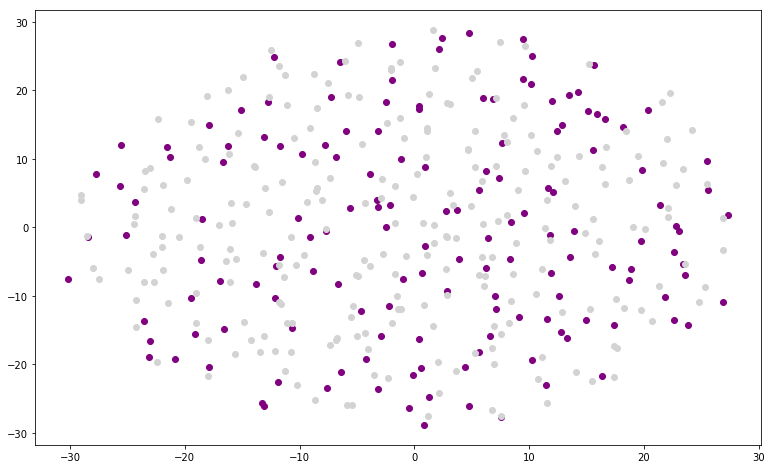

             precision    recall  f1-score   support

      other       0.66      0.54      0.59      1441
       earn       0.42      0.54      0.47       890

avg / total       0.57      0.54      0.55      2331

Average loss at step 2000: 2.5
Test loss at step 2000: 4.5
Average loss at step 4000: 2.5
Test loss at step 4000: 4.5
Average loss at step 6000: 2.5
Test loss at step 6000: 4.5
Average loss at step 8000: 2.5
Test loss at step 8000: 4.5
Average loss at step 10000: 2.5
Test loss at step 10000: 4.5
Average loss at step 12000: 2.5
Test loss at step 12000: 4.4
Average loss at step 14000: 2.4
Test loss at step 14000: 4.4
Average loss at step 16000: 2.4
Test loss at step 16000: 4.4
Average loss at step 18000: 2.4
Test loss at step 18000: 4.4
Average loss at step 20000: 2.4
Test loss at step 20000: 4.4
Average loss at step 22000: 2.4
Test loss at step 22000: 4.4
Average loss at step 24000: 2.4
Test loss at step 24000: 4.4
Average loss at step 26000: 2.4
Test loss at step 26000: 4.4


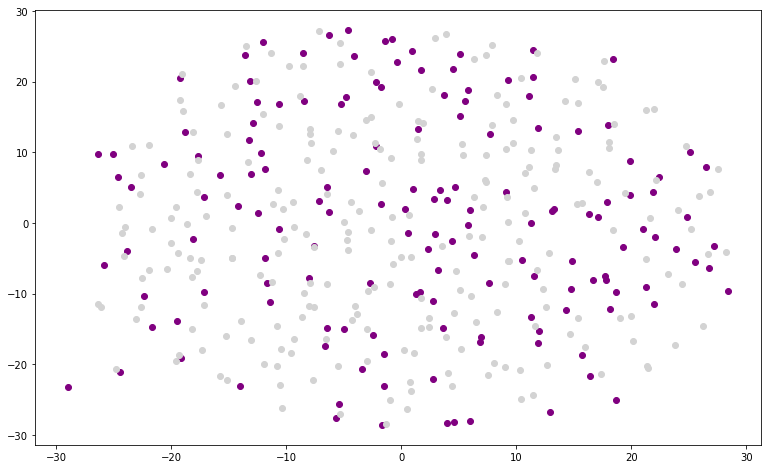

             precision    recall  f1-score   support

      other       0.69      0.56      0.62      1441
       earn       0.45      0.58      0.51       890

avg / total       0.60      0.57      0.58      2331

Average loss at step 2000: 2.4
Test loss at step 2000: 4.3
Average loss at step 4000: 2.3
Test loss at step 4000: 4.3
Average loss at step 6000: 2.3
Test loss at step 6000: 4.3
Average loss at step 8000: 2.3
Test loss at step 8000: 4.3
Average loss at step 10000: 2.3
Test loss at step 10000: 4.3
Average loss at step 12000: 2.3
Test loss at step 12000: 4.3
Average loss at step 14000: 2.3
Test loss at step 14000: 4.3
Average loss at step 16000: 2.3
Test loss at step 16000: 4.3
Average loss at step 18000: 2.3
Test loss at step 18000: 4.3
Average loss at step 20000: 2.3
Test loss at step 20000: 4.2
Average loss at step 22000: 2.3
Test loss at step 22000: 4.2
Average loss at step 24000: 2.3
Test loss at step 24000: 4.2
Average loss at step 26000: 2.2
Test loss at step 26000: 4.2


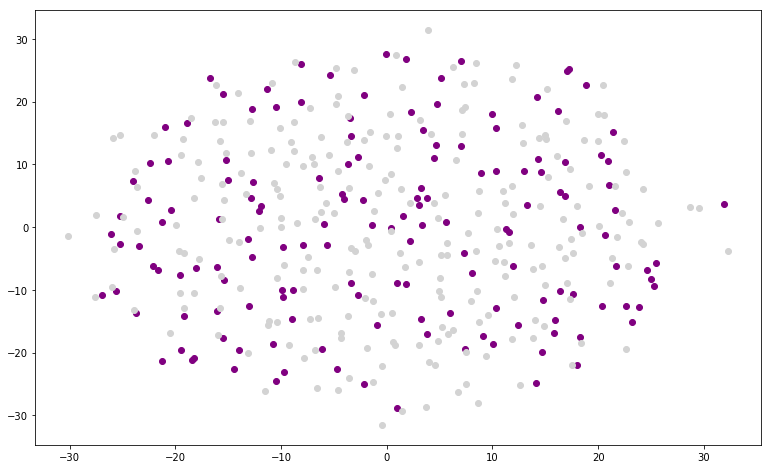

             precision    recall  f1-score   support

      other       0.72      0.61      0.66      1441
       earn       0.49      0.62      0.55       890

avg / total       0.63      0.61      0.62      2331

Average loss at step 2000: 2.2
Test loss at step 2000: 4.2
Average loss at step 4000: 2.2
Test loss at step 4000: 4.2
Average loss at step 6000: 2.2
Test loss at step 6000: 4.2
Average loss at step 8000: 2.2
Test loss at step 8000: 4.2
Average loss at step 10000: 2.2
Test loss at step 10000: 4.2


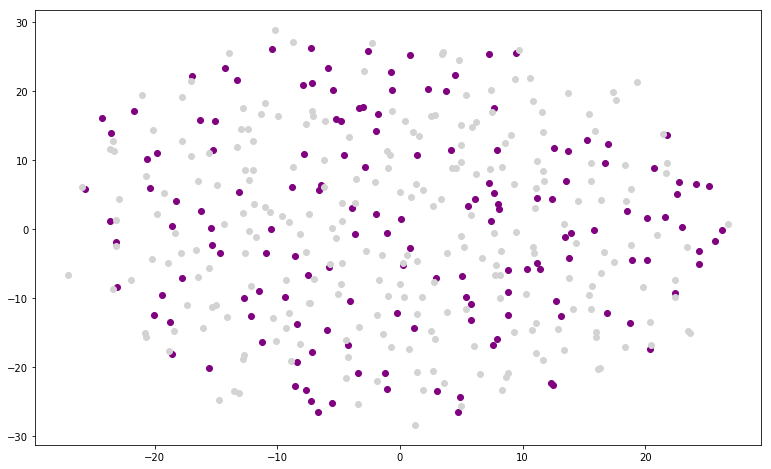

             precision    recall  f1-score   support

      other       0.73      0.61      0.66      1441
       earn       0.50      0.63      0.56       890

avg / total       0.64      0.62      0.62      2331



In [50]:

def classification_experiment(embeddings):
    X = embeddings[e2e_train, :]
    y = e2e_labels[e2e_train]
    clf = svm.SVC(kernel='linear', class_weight='balanced')
    clf.fit(X, y)
    predictions = clf.predict(
            embeddings[~e2e_train, :])
    print(classification_report(
            e2e_labels[~e2e_train],
            predictions, target_names=target_names))
    

def end_to_end(num_steps):
    train(num_steps)
    current_embeddings = session.run(normalized_embeddings)
    plot(get_two_d_embeddings(current_embeddings))
    classification_experiment(current_embeddings)
    

def run():
    for i in range(NUM_STEPS // END_TO_END_EVERY_X_STEPS):
        end_to_end(END_TO_END_EVERY_X_STEPS)
    end_to_end(NUM_STEPS % END_TO_END_EVERY_X_STEPS)
    

run()